# Final Project - E-Commerce: Product Range Analysis

# Project description

**In order to increase sales, our client, an E-Commerce business, have asked us to analyze the store's product range.**

**In the process of product range analysis, we will take a closer look at our products and our clients' behaviour. <br>
Analysis of the product range can help us bundle our products into clusters which will help displaying the products to the users in more comfortable way and help us competently offer additional products to buyers and optimize purchases, and eventually make decisions on whether we need to refresh our stock with more exciting products of the same category or remove other products from our inventory.**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
from scipy import stats as st
import numpy as np
import seaborn as sns
import difflib
from statistics import mode
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
import nltk
from nltk.stem.snowball import SnowballStemmer
from IPython.display import display, Markdown, Latex

snow_stemmer = SnowballStemmer(language='english')

# Functions

In [2]:
def up(df, column):
    return df.sort_values(by = column, ascending = False)
    
def down(df, column):
    return df.sort_values(by = column, ascending = True)

In [3]:
def position(df, column):
    for i in range(0, len(df)):
        df.loc[i, column + '_position'] = i + 1
    return df

In [4]:
def scatter(title, x_col, y_col, xlabel, ylabel):
    positions.plot(kind = 'scatter', 
          x = x_col, 
          y = y_col, 
          figsize = (12,5),
          alpha = 0.4)
    plt.xlabel(xlabel, fontsize = 14)
    plt.ylabel(ylabel, fontsize = 14)
    plt.title(title, fontsize = 16)
    plt.show()

In [5]:
def stem_description(description):
    desc_stemmed = []
    for word in description.split(' '):
        if (len(word) > 2) &  word.isalpha():
            stemmed = snow_stemmer.stem(word)
            desc_stemmed.append(stemmed)
        else:
            pass
    if len(desc_stemmed) > 0:
        return desc_stemmed
    else:
        return np.nan

In [6]:
def top_keywords(description):
    result = []
    for word in description.split():
        word = snow_stemmer.stem(word)
        if word in words.index:
            result.append(words.loc[word, 'word_count'])
        else:
            pass
    if len(result) == 0:
        result.append(0)
    return pd.Series(sorted(result, reverse = True))

In [7]:
def categorization(description):
    for word in description.split():
        word = snow_stemmer.stem(word)
        if any(word in description for word in appear_and_accessories):
            return 'appear and accessories', '1'
        elif any(word in description for word in office_supplies):
             return 'office supplies', '2'
        elif any(word in description for word in kids):
            return 'kids', '3'
        elif any(word in description for word in holidays_and_parties):
            return 'holidays and parties', '4'
        elif any(word in description for word in garden):
            return 'garden', '5'
        elif any(word in description for word in home):
            return 'home', '6' 
        elif any(word in description for word in kitchen):
            return 'kitchen', '7'
        else:
            return 'other', '8'

In [8]:
def column_change(df, placed_column, replaced_column):
    temp = df[replaced_column].copy()
    df[replaced_column] = df[placed_column]
    df[placed_column] = temp
    df.rename(columns = {placed_column:'temp'}, inplace = True)
    df.rename(columns = {replaced_column:placed_column}, inplace = True)
    df.rename(columns = {'temp':replaced_column}, inplace = True)

In [9]:
def more_than_1(df, column_1, column_2):
    num_descriptions = df.groupby(column_1)[column_2].nunique().reset_index()
    more_than_1 = num_descriptions[num_descriptions[column_2] > 1].reset_index(drop = True)
    more_than_1 = more_than_1.rename({column_2: 'num_of_descriptions'}, axis = 1)
    return up(more_than_1, 'num_of_descriptions')

In [10]:
def clusters_table(cluster_num, report, mean):
    title = str(cluster_num)
    if title != 'all_clusters': 
            df = items[items['cluster'] == cluster_num]
            df_copy = df.drop(['stock_code', 'stock_number', 'quantity', 'cluster',
                               'total_revenue', 'invoice_count', '1st_word_count', '2nd_word_count', 
                               '3rd_word_count', 'category_num', 'unit_price'], axis = 1)
            
            column_change(df_copy, 'category', 'num_versions')
            column_change(df_copy, 'total_revenue_position', 'more_than_1')
            column_change(df_copy, 'quantity_position', 'more_than_1')
            column_change(df_copy, 'unit_price_position', 'more_than_1')
            column_change(df_copy, 'invoice_count_position', 'more_than_1')
            column_change(df_copy, 'more_than_1', 'num_versions')
            
            groupby = 'category'
            
            if mean != 'yes':
                display(Markdown('#### Cluster ' + title))
                display(df_copy.head())
    else: 
        df = items
        groupby = 'cluster'

    
    table = df.groupby(groupby).agg({'stock_code': 'count',
                                     'total_revenue': ['sum', 'mean'],
                                     'quantity':'mean', 
                                     'unit_price': 'mean', 
                                     'stock_number': 'nunique',
                                     'num_versions': 'mean',
                                     'more_than_1': 'mean'})

    table.columns = ['total_items', 'total_revenue', 'avg_revenue_per_item',
                     'avg_quantity', 'avg_item_price', 'unique_items', 'avg_num_versions',
                     'more_than_1']
    
    table = up(table, 'total_revenue')
    
    table['revenue_perc'] = ((table['total_revenue'] / table['total_revenue'].sum()) * 100).round(2)
    
    f = {'total_items':'{:.2f}', 'total_revenue':'{:.2f}', 'avg_revenue_per_item':'{:.2f}', 'avg_quantity':'{:.2f}',
         'avg_item_price':'{:.2f}', 'unique_items':'{:.2f}', 'avg_num_versions':'{:.2f}', 'more_than_1':'{:.2f}',
         'revenue_perc':'{:.2f}'}

    if report == 'no':
        display(table.style.highlight_max(color = '#97DFA1').format(f).highlight_min(color = '#FCA965'))
        
    df = df.filter(['description', 'quantity', 'total_revenue', 'num_versions', 'invoice_count',
                    'unit_price', 'cluster'], axis = 1)
    
    
    if title != 'all_clusters':
        return df
    else:
        return table

In [11]:
def cluster_report(cluster_num):
    
    all_clusters = clusters_table('all_clusters', 'yes', 'yes')

    for i in range(0, 6):
        all_clusters.loc[i, 'total_quantity'] = clusters_table(i, 'yes', 'yes')['quantity'].sum()
        all_clusters.loc[i, 'total_invoices'] = clusters_table(i, 'yes', 'yes')['invoice_count'].sum()

    cluster_df = clusters_table(cluster_num, 'no', 'no')
                
    describe = cluster_df.describe().round(2)

    total = describe.loc['count', 'quantity']
    revenue = all_clusters.loc[cluster_num, 'total_revenue'].round(2)
    index_revenue = up(all_clusters, 'total_revenue').reset_index()
    index_revenue = index_revenue[index_revenue['cluster'] == cluster_num].index[0] + 1
    revenue_perc = all_clusters.loc[cluster_num, 'revenue_perc'].astype(str) + '%'
    revenue_min = describe.loc['min', 'total_revenue']
    revenue_max = describe.loc['max', 'total_revenue']
    revenue_mean = describe.loc['mean', 'total_revenue']

    quantity = all_clusters.loc[cluster_num, 'total_quantity']
    index_quantity = up(all_clusters, 'total_quantity').reset_index()
    index_quantity = index_quantity[index_quantity['cluster'] == cluster_num].index[0] + 1
    quantity_min = describe.loc['min', 'quantity']
    quantity_max = describe.loc['max', 'quantity']
    quantity_mean = describe.loc['mean', 'quantity']

    unit_price_min = describe.loc['min', 'unit_price']
    unit_price_max = describe.loc['max', 'unit_price']
    unit_price_mean = describe.loc['mean', 'unit_price']

    num_versions_min = describe.loc['min', 'num_versions']
    num_versions_max = describe.loc['max', 'num_versions']
    num_versions_mean = describe.loc['mean', 'num_versions']

    invoice = all_clusters.loc[cluster_num, 'total_invoices']
    index_invoice = up(all_clusters, 'total_invoices').reset_index()
    index_invoice = index_invoice[index_invoice['cluster'] == cluster_num].index[0] + 1
    invoice_min = describe.loc['min', 'invoice_count']
    invoice_max = describe.loc['max', 'invoice_count']
    invoice_mean = describe.loc['mean', 'invoice_count']
    
    df = (categories.transpose().drop(['total']) * 100).reset_index().round(2)
    df = df.rename(columns={'index': 'category'})
    
    st_name = up(df, cluster_num).reset_index(drop = True).loc[0, 'category']
    st_perc = up(df, cluster_num).reset_index(drop = True).loc[0, cluster_num].astype(str) + '%'
    nd_name = up(df, cluster_num).reset_index(drop = True).loc[1, 'category']
    nd_perc = up(df, cluster_num).reset_index(drop = True).loc[1, cluster_num].astype(str) + '%'
    rd_name = up(df, cluster_num).reset_index(drop = True).loc[2, 'category']
    rd_perc = up(df, cluster_num).reset_index(drop = True).loc[2, cluster_num].astype(str) + '%'
    

    display(Markdown(('**Total items:** There are {:.0f} items in the cluster <br> \
                       **Revenue:** <br> \
                         &emsp; **Total:** {} ({}, {}) <br> \
                         &emsp; **Range:** {} - {} <br> \
                         &emsp; **Mean:** {} <br> \
                        **Quantity:**  <br> \
                         &emsp; **Total items sold:** {:.0f} ({}) <br> \
                         &emsp; **Range:** {} - {} <br> \
                         &emsp; **Mean:** {} <br> \
                         **Categories:** <br> \
                         &emsp; **1st category:** {} ({}) <br> \
                         &emsp; **2nd category:** {} ({}) <br> \
                         &emsp; **3rd category:** {} ({}) <br> \
                        **Unit price:**  <br> \
                         &emsp; **Range:** {} - {} <br> \
                         &emsp; **Mean:** {} <br> \
                        **Number of versions:**  <br> \
                         &emsp; **Range:** {} - {} <br> \
                         &emsp; **Mean:** {} <br> \
                        **Number of invoices the items appeared in:** <br> \
                         &emsp; **Total:** {} ({}) <br> \
                         &emsp; **Range:** {} - {} <br> \
                         &emsp; **Mean:** {} <br>')
                      .format(total,
                              revenue, index_revenue, revenue_perc, revenue_min, revenue_max, revenue_mean,
                              quantity, index_quantity, quantity_min, quantity_max, quantity_mean,
                              st_name, st_perc, nd_name, nd_perc, rd_name, rd_perc,
                              unit_price_min, unit_price_max, unit_price_mean,
                              num_versions_min, num_versions_max, num_versions_mean,
                              invoice, index_invoice, invoice_min, invoice_max, invoice_mean)))
    life_cycle(cluster_df)

In [12]:
def life_cycle(cluster_df):
    cluster_df = cluster_df.head(20) 
    cluster_df = pd.merge(df, cluster_df[['description','cluster']], on = 'description', how = 'left')
    cluster_df = cluster_df[cluster_df['cluster'].notna()]
    
    first_order_date = cluster_df.groupby(['description'])['invoice_date'].min()
    first_order_date.name = 'first_order_date'

    orders = cluster_df.join(first_order_date, on = 'description')
    orders['order_month'] = orders['date'].astype('datetime64[M]')
    orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
    
    order_pivot = orders.pivot_table(index = 'first_order_month', columns = 'order_month', values = 'revenue', aggfunc = 'sum')
    
    order_pivot.index = order_pivot.index.astype(str)
    order_pivot.columns = order_pivot.columns.astype(str)

    plt.figure(figsize = (19, 4))
    sns.heatmap(order_pivot, 
                annot = True, 
                fmt = '.2f', 
                linewidths = 1, 
                linewidth = 0.5, 
                linecolor = 'black',
                ).set(title ='Total monthly top 50 flagships revenue')
    plt.show()

## Download and preprocess the data

### Open the data file and study the general information

In [13]:
df = pd.read_csv('/datasets/ecommerce_dataset_us.csv', sep = '\t',
                 parse_dates = ['InvoiceDate'])

In [14]:
print(df.info())
missing_values = df.isnull().sum().reset_index().rename(columns = {0: 'missing_values'})
print(df.describe())
missing_values['%'] = (missing_values['missing_values'] / 541909) * 100
missing_values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 28.9+ MB
None
            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000

,index,missing_values,%
0,InvoiceNo,0,0.000000
1,StockCode,0,0.000000
2,Description,1454,0.268311
3,Quantity,0,0.000000
4,InvoiceDate,0,0.000000
5,UnitPrice,0,0.000000
6,CustomerID,135080,24.926694


**Looking at the information, we have 7 columns, all columns need their name to be changed according to the convention. let's see how we can preprocess each of them individually.**

**1) InvoiceNo - Need to look for anomal values. We can see this column is defined as object, so there might be some wrong values in that column. Also since invoice numbers are individual, we need to check that there are no duplicates based on the number, date(make sure this number was used only in specific date) and customer ID(make sure no 2 customers recived the same invoice number at the same day).**

**2) StockCode - Also make sure there are no anomal values. Make sure there aren't several products with the same code.**

**3) Description - Need make sure all the descriptions actually contain a product.
We have 0.26% of missing values, we can try fill them with using the stock_code and mode() method.**

**4) Quantity - Looking at the descrpition above, looks like there will be anomalies. We can't have quantity with negative value and probably not with such a high number such as the max value in that column.**

**5) InvoiceDate - Look at the range of the dates, make sure it makes sence, and change the data type to date type.**

**6) UnitPrice - Also contain anomalies according to the description. The price has to be positive and be reasonable. If necessary, we can use the mode() method to fill prices with anormal values.**

**7) CustomerID - Almost 25% of missing values. We can try using the mode() method on the invoice_number to fill null values in this column. Other than that, we might not be able to use those rows to calculate retention rate, but we can still use them for the product range analysis.**

### Preprocess the data

#### **Changing column names according to convention, and making sure there are only lower case letters in the dataframe in order to find duplicates.**

In [15]:
df.rename(columns = {'InvoiceNo':   'invoice_number',
                     'StockCode':   'stock_code',
                     'Description': 'description',
                     'Quantity':    'quantity',
                     'InvoiceDate':   'invoice_date',
                     'UnitPrice':   'unit_price',
                     'CustomerID':   'customer_id'}, inplace=True)
df = df.applymap(lambda s:s.lower() if type(s) == str else s)
df.head()

,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id
0,536365,85123a,white hanging heart t-light holder,6,2018-11-29 08:26:00,2.55,17850.0
1,536365,71053,white metal lantern,6,2018-11-29 08:26:00,3.39,17850.0
2,536365,84406b,cream cupid hearts coat hanger,8,2018-11-29 08:26:00,2.75,17850.0
3,536365,84029g,knitted union flag hot water bottle,6,2018-11-29 08:26:00,3.39,17850.0
4,536365,84029e,red woolly hottie white heart.,6,2018-11-29 08:26:00,3.39,17850.0


#### Looking for duplicates

In [16]:
print('Number of duplicated rows: {}({:.2%})'.format(df.duplicated().sum(), df.duplicated().sum() / len(df)))

Number of duplicated rows: 5268(0.97%)


In [17]:
df = df.drop_duplicates()

In [18]:
df[df['invoice_number'] == 'a563185']

,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id
299982,a563185,b,adjust bad debt,1,2019-08-10 14:50:00,11062.06,NaN


#### invoice_number column:

In [19]:
letters_in_invoice = df[(df['invoice_number'].str.contains('[a-zA-Z]'))].reset_index()
letters_in_invoice.head()

,index,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id
0,141,c536379,d,discount,-1,2018-11-29 09:41:00,27.50,14527.0
1,154,c536383,35004c,set of 3 coloured flying ducks,-1,2018-11-29 09:49:00,4.65,15311.0
2,235,c536391,22556,plasters in tin circus parade,-12,2018-11-29 10:24:00,1.65,17548.0
3,236,c536391,21984,pack of 12 pink paisley tissues,-24,2018-11-29 10:24:00,0.29,17548.0
4,237,c536391,21983,pack of 12 blue paisley tissues,-24,2018-11-29 10:24:00,0.29,17548.0


**Some invoices start with a letter. They also have negative quantity. Let's see if there are letters other than c in the invoice numbers**

In [20]:
letters_in_invoice['invoice_number'] = letters_in_invoice['invoice_number'].str.replace('\d+', '', regex = True)

In [21]:
letters_in_invoice['invoice_number'].unique()

array(['c', 'a'], dtype=object)

**There are numbers with the letters 'a' and 'c'.<br>
Let's look at invoices that contain the letter 'a':**

In [22]:
a_in_invoice = letters_in_invoice[letters_in_invoice['invoice_number'] == 'a']
a_in_invoice

,index,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id
5436,299982,a,b,adjust bad debt,1,2019-08-10 14:50:00,11062.06,NaN
5437,299983,a,b,adjust bad debt,1,2019-08-10 14:51:00,-11062.06,NaN
5438,299984,a,b,adjust bad debt,1,2019-08-10 14:52:00,-11062.06,NaN


**We don't know yet what the 'c' means, but the 'a' is not for item purchases, so we can drop rows with 'a' in the invoice number.**

In [23]:
df.drop(a_in_invoice['index'], inplace = True)
df = df.reset_index(drop = True)

In [24]:
c_in_invoice = df[(df['invoice_number'].str.contains('[c]'))].reset_index()
print('Number of invoice numbers with c in them:', len(c_in_invoice))
print('Number of invoice numbers with c in them and negative quantity:', len(c_in_invoice[c_in_invoice['quantity'] <= 0]))

Number of invoice numbers with c in them: 9251
Number of invoice numbers with c in them and negative quantity: 9251


In [25]:
df.drop(c_in_invoice['index'], inplace = True)
df = df.reset_index(drop = True)

**All the invoice numbers that contain the letter c has negative quantity. We can ask the data engineers what does it mean, but meanwhile we can drop it.**

#### stock_code column:

In [26]:
letters_in_code = df[(df['stock_code'].str.contains('[a-zA-Z]'))].reset_index()
letters_in_code.head()

,index,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id
0,0,536365,85123a,white hanging heart t-light holder,6,2018-11-29 08:26:00,2.55,17850.0
1,2,536365,84406b,cream cupid hearts coat hanger,8,2018-11-29 08:26:00,2.75,17850.0
2,3,536365,84029g,knitted union flag hot water bottle,6,2018-11-29 08:26:00,3.39,17850.0
3,4,536365,84029e,red woolly hottie white heart.,6,2018-11-29 08:26:00,3.39,17850.0
4,45,536370,post,postage,3,2018-11-29 08:45:00,18.00,12583.0


**Let's separate codes with only letters from codes that combine letters and numbers.**

In [27]:
letters = letters_in_code[letters_in_code['stock_code'].str.isalpha()]
letters.groupby('stock_code')['description'].value_counts()

stock_code  description               
amazonfee   amazon fee                       2
dcgssboy    boys party bag                  11
dcgssgirl   girls party bag                 13
dot         dotcom postage                 708
m           manual                         323
pads        pads to match all cushions       4
post        postage                       1126
s           samples                          2
Name: description, dtype: int64

**Only boys' and girls' party bags are actually products. Let's drop the rest.**

In [28]:
drop = letters[(letters['stock_code'] != 'dcgssboy') & (letters['stock_code'] != 'dcgssgirl')]
df.drop(drop['index'], inplace = True)

In [29]:
combine = df[(~df['stock_code'].str.isdigit()) & (~df['stock_code'].str.isalpha())].reset_index(drop = True)
combine.head()

,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id
0,536365,85123a,white hanging heart t-light holder,6,2018-11-29 08:26:00,2.55,17850.0
1,536365,84406b,cream cupid hearts coat hanger,8,2018-11-29 08:26:00,2.75,17850.0
2,536365,84029g,knitted union flag hot water bottle,6,2018-11-29 08:26:00,3.39,17850.0
3,536365,84029e,red woolly hottie white heart.,6,2018-11-29 08:26:00,3.39,17850.0
4,536373,85123a,white hanging heart t-light holder,6,2018-11-29 09:02:00,2.55,17850.0


In [30]:
combine['stock_number'] = combine['stock_code'].str.replace('[a-zA-Z]', '', regex = True)

len(more_than_1(combine, 'stock_number', 'description'))

296

In [31]:
more_than_1(combine, 'stock_number', 'description').head()

,stock_number,num_of_descriptions
294,90214,24
186,85049,10
172,84997,9
52,46000,8
78,72802,8


**There are 296 stock codes that have letter in their stock code. Let's look at a sample and see if we can come up with conclusions.**

In [32]:
print(df[df['stock_code'].str.contains('15044')]['stock_code'].unique())
df[df['stock_code'].str.contains('15044')]['description'].unique()

['15044b' '15044c' '15044d' '15044a']


array(['blue paper parasol ', 'purple paper parasol', 'red paper parasol',
       'pink paper parasol ', nan], dtype=object)

**Looks like the letters in stock_code column implies the same product have several versions (different colors in that case.)<br>
After I'll finish the preprocess, I will count the number of versions for each item.**

In [33]:
df['stock_number'] = df['stock_code'].str.replace('[a-zA-Z]', '', regex = True)

#### description column:

**Let's take a look at the the rows with missing description.**

In [34]:
df[(df['description'].isna())].head()

,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id,stock_number
596,536414,22139,NaN,56,2018-11-29 11:52:00,0.0,NaN,22139
1922,536545,21134,NaN,1,2018-11-29 14:32:00,0.0,NaN,21134
1923,536546,22145,NaN,1,2018-11-29 14:33:00,0.0,NaN,22145
1924,536547,37509,NaN,1,2018-11-29 14:33:00,0.0,NaN,37509
1925,536549,85226a,NaN,1,2018-11-29 14:34:00,0.0,NaN,85226


**Let's take a look at the stock_code of the first row and see if we can find the description.**

In [35]:
df[(df['stock_code'] == '22139')].head()

,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id,stock_number
106,536381,22139,retrospot tea set ceramic 11 pc,23,2018-11-29 09:41:00,4.25,15311.0,22139
596,536414,22139,NaN,56,2018-11-29 11:52:00,0.00,NaN,22139
6215,536942,22139,amazon,15,2018-12-01 12:08:00,0.00,NaN,22139
6700,536982,22139,retrospot tea set ceramic 11 pc,10,2018-12-01 14:27:00,11.02,NaN,22139
7018,537011,22139,NaN,-5,2018-12-01 15:38:00,0.00,NaN,22139


**We have found very peculiar resaults. Same stock_code have 2 different descriptions. One is the "amazon" description that I can't tell anything about it yet and the other is probably the actual description. We will address the "amazon" description and negative quantity issues later.**

**Meanwhile, let's find stock codes with more than 1 description that we can try use to fill the NaN values or with 0 descriptions - only NaN values**

In [36]:
code_desc_num = df.groupby('stock_code')['description'].nunique().reset_index()
code_desc_num[(code_desc_num['description'] > 1) | (code_desc_num['description'] == 0)].head()

,stock_code,description
1,10080,2
4,10123g,0
8,10133,2
9,10134,0
23,15058a,2


In [37]:
df['description'] = df.groupby('stock_code')['description'].transform(lambda grp:grp.fillna(grp.mode().max()))

**Left with stock codes that only have NaN as description, thus we can't fill their values so we have to drop them.**

In [38]:
df.dropna(subset = ['description'], inplace = True)

In [39]:
more_than_1(df, 'stock_code', 'description').head()

,stock_code,num_of_descriptions
314,23084,7
25,20713,7
621,85175,6
137,21830,6
68,21181,5


**Still have codes with more than one description. I will use the mode() method again to make sure each code have one description.<br>
NOTE: We had descriptions such as "broken" or "damaged". Those descriptions usually had no customer ID or had negative quantity or price, so this bad rows will be addressed in the following stages.**

In [40]:
df['description'] = df.groupby('stock_code')['description'].transform(lambda grp:mode(grp))
df['stock_code'] = df.groupby('description')['stock_code'].transform(lambda grp:mode(grp))
df['description'] = df.groupby('stock_code')['description'].transform(lambda grp:mode(grp))

In [41]:
more_than_1(df, 'stock_code', 'description')

,stock_code,num_of_descriptions


**Made unified description for each stock_code.**

#### quantity column:

In [42]:
none_to_negative = df[df['quantity'] <= 0].reset_index()
none_to_negative.head()

,index,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id,stock_number
0,2336,536589,21777,recipe box with metal heart,-10,2018-11-29 16:50:00,0.0,NaN,21777
1,4249,536764,84952c,mirror love bird t-light holder,-38,2018-11-30 14:42:00,0.0,NaN,84952
2,7003,536996,22712,card dolly girl,-20,2018-12-01 15:30:00,0.0,NaN,22712
3,7004,536997,22028,penny farthing birthday card,-20,2018-12-01 15:30:00,0.0,NaN,22028
4,7005,536998,85067,cream sweetheart wall cabinet,-6,2018-12-01 15:30:00,0.0,NaN,85067


**Looks like lot of the negative quantities also have no price and customer_id.<br>
Let's see how many of the rows are such.**

In [43]:
print('Missing customer ID:', len(none_to_negative[none_to_negative['customer_id'].isna()]))
print('Missing customer ID with no price:', len(none_to_negative[(none_to_negative['unit_price'] == 0) &
                                                                 (none_to_negative['customer_id'].isna())]))
print('Number of mutual invoice numbers for the original df and none_to_negative df:', len(df[df['invoice_number'].isin(none_to_negative['invoice_number'])]))

Missing customer ID: 1235
Missing customer ID with no price: 1235
Number of mutual invoice numbers for the original df and none_to_negative df: 1235


**We have found that all of the rows with negative quantities also have no price and customer_id.<br>
Also made sure each invoice number in the none_to_negative only appears once in the original df.**

In [44]:
df.drop(none_to_negative['index'], inplace = True)
df = df.reset_index(drop = True)

df[df['quantity'] <= 0]

,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id,stock_number


#### invoice_date column:

In [45]:
df['invoice_date'].describe(datetime_is_numeric = True)

count                           523868
mean     2019-07-02 14:48:15.227919872
min                2018-11-29 08:26:00
25%                2019-03-26 11:58:00
50%                2019-07-18 11:22:00
75%                2019-10-17 11:41:00
max                2019-12-07 12:50:00
Name: invoice_date, dtype: object

**The first and last dates of purchases make sence. Also made sure the column is in date type while reading the data frame.**

#### unit_price column:

In [46]:
none_to_negative = df[df['unit_price'] <= 0].reset_index()
display(none_to_negative.head())
print('Number of units with negative price: ', len(df[df['unit_price'] < 0]))
print('Number of units with 0 price: ', len(df[df['unit_price'] == 0]))

,index,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id,stock_number
0,594,536414,22139,retrospot tea set ceramic 11 pc,56,2018-11-29 11:52:00,0.0,NaN,22139
1,1918,536546,22145,christmas craft heart stocking,1,2018-11-29 14:33:00,0.0,NaN,22145
2,1919,536547,37509,new england mug w gift box,1,2018-11-29 14:33:00,0.0,NaN,37509
3,1951,536553,37461,funky monkey mug,3,2018-11-29 14:35:00,0.0,NaN,37461
4,4236,536765,84952c,mirror love bird t-light holder,19,2018-11-30 14:43:00,0.0,NaN,84952


Number of units with negative price:  0
Number of units with 0 price:  1147


In [47]:
df['unit_price'] = df.groupby('stock_code')['unit_price'].transform(lambda grp:mode(grp))
df['unit_price'] = df.groupby('description')['unit_price'].transform(lambda grp:mode(grp))

**Made sure all of the same stock codes and descriptions, also have the same unit price with mode() method.**

In [48]:
print('Number of units with negative price: ', len(df[df['unit_price'] < 0]))
print('Number of units with 0 price: ', len(df[df['unit_price'] == 0]))

Number of units with negative price:  0
Number of units with 0 price:  45


In [49]:
df[df['unit_price'] == 0].head()

,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id,stock_number
1918,536546,22145,christmas craft heart stocking,1,2018-11-29 14:33:00,0.0,NaN,22145
1919,536547,37509,new england mug w gift box,1,2018-11-29 14:33:00,0.0,NaN,37509
1951,536553,37461,funky monkey mug,3,2018-11-29 14:35:00,0.0,NaN,37461
8994,537199,37509,new england mug w gift box,1,2018-12-03 14:06:00,0.0,15894.0,37509
9294,537209,37461,funky monkey mug,1,2018-12-03 15:12:00,0.0,14606.0,37461


**We still have rows with 0 as unit price. It occured because some stock codes or descriptions don't have any price in the df so we couldn't replace the 0 with the mode() method. I will drop these rows since I can't fill in the price by description or by stock code.**

In [50]:
df = df[df['unit_price'] > 0].reset_index(drop = True)

#### customer_id column:

In [51]:
missing_id = df[df['customer_id'].isna()]
print('% of missing customer ID: {:.2%}'.format(len(missing_id) / len(df))) 

% of missing customer ID: 25.30%


**We have 25% of the rows with missing customer ID. Let's see if we can fill them. I will use the invoice number and see if I can find customer ID for the invoice number in the original df**

In [52]:
invoice_list = missing_id['invoice_number'].unique()

In [53]:
df[(df['invoice_number'].isin(invoice_list)) & (df['customer_id'].notna())]

,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id,stock_number


**There are no rows with missing customer ID that have customer ID in the original df.<br>
I will leave the missing cusomer ID as they are since it won't affect us too much in the proccess.**

In [54]:
df[(df['invoice_number'] == '536409') & (df['description'] == 'union jack flag luggage tag')]

,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id,stock_number
483,536409,21866,union jack flag luggage tag,1,2018-11-29 11:45:00,1.25,17908.0,21866


## Exploratory data analysis

### Outliers

**After preprocessing the data, let's use the describe() method again to see if we still have outliers in the quantity and unit_price columns.**

#### quantity column:

In [55]:
df['quantity'].describe()

count    523823.000000
mean         10.743963
std         157.859565
min           1.000000
25%           1.000000
50%           4.000000
75%          12.000000
max       80995.000000
Name: quantity, dtype: float64

**There are high outliers in the quantity column. it is not reasonable to order over 80 thousand units of any item. Let's look at the boxplot.**

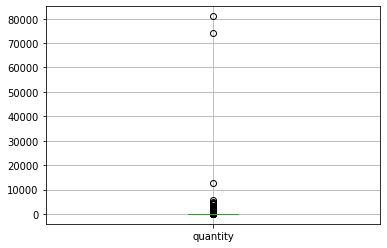

In [56]:
df.boxplot('quantity')

plt.show()

**We can see in the boxplot that there are several significant outliers that we need to get rid of.<br> Let's set the higher limit to 10,000 units. It is reasonable to order small items in bulks this size.**

In [57]:
df = df.query('quantity < 10000')

up(df, 'quantity').head(10)

,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id,stock_number
72085,542504,37413,icon mug revolutionary,5568,2019-01-26 12:03:00,0.39,NaN,37413
407391,573008,84077,world war 2 gliders asstd designs,4800,2019-10-25 12:26:00,0.29,12901.0,84077
199093,554868,22197,popcorn holder,4300,2019-05-25 10:52:00,0.85,13135.0,22197
213329,556231,85123a,white hanging heart t-light holder,4000,2019-06-07 15:04:00,2.95,NaN,85123
94040,544612,22053,empire design rosette,3906,2019-02-20 10:43:00,1.25,18087.0,22053
261670,560599,18007,essential balm 3.5g tin in envelope,3186,2019-07-17 17:04:00,0.18,14609.0,18007
154934,550461,21108,fairy cake flannel assorted colour,3114,2019-04-16 13:20:00,0.79,15749.0,21108
50898,540815,21108,fairy cake flannel assorted colour,3114,2019-01-09 12:55:00,0.79,15749.0,21108
254943,560040,23343,jumbo bag vintage christmas,3100,2019-07-12 14:28:00,2.08,NaN,23343
419207,573995,16014,small chinese style scissor,3000,2019-10-31 11:24:00,0.42,16308.0,16014


**Now the highest quantity is less than 6,000 which is OK. The highest quantities are for cheap items that can be ordered in big bulks.**

#### unit_price column

In [58]:
df['unit_price'].describe()

count    523820.000000
mean          2.831028
std           3.658990
min           0.040000
25%           1.250000
50%           1.950000
75%           3.750000
max         165.000000
Name: unit_price, dtype: float64

**In the unit price column, we do have outliers, but they are not un-reasonable. It makes sence that a product would cost 165$\$$ , but 0.06$\$$ is a little too low, so I will make sure all items cost at least 0.5$\$$**

In [59]:
df = df[df['unit_price'] >= 0.5]

### Product analysis

#### Number of purchases by date column

In [60]:
df['date'] = pd.to_datetime(df['invoice_date'].dt.date)
df['year'] = df['invoice_date'].dt.year
df['month'] = df['invoice_date'].dt.month 
df['week'] = df['invoice_date'].dt.isocalendar().week

In [61]:
daily_total = df.groupby(['date', 'week' ,'month', 'year']).agg({'invoice_number': 'nunique'}).reset_index()
daily_total.rename(columns = {'invoice_number':'daily_purchases'}, inplace = True)
dap = daily_total.copy()
dap['daily_purchases'] = dap['daily_purchases'].mean()
dap_num = dap.loc[0, 'daily_purchases']
dap = dap.groupby(['week','month', 'year']).mean()
dap = dap.sort_values(by = ['year', 'month', 'week'], ascending = True)

In [62]:
weekly_dap = daily_total.groupby(['week','month', 'year']).mean()
weekly_dap = weekly_dap.sort_values(by = ['year', 'month', 'week'], ascending = True)
weekly_dap.reset_index(inplace = True)
weekly_dap.rename(columns = {'daily_purchases':'weekly_dap'}, inplace = True)

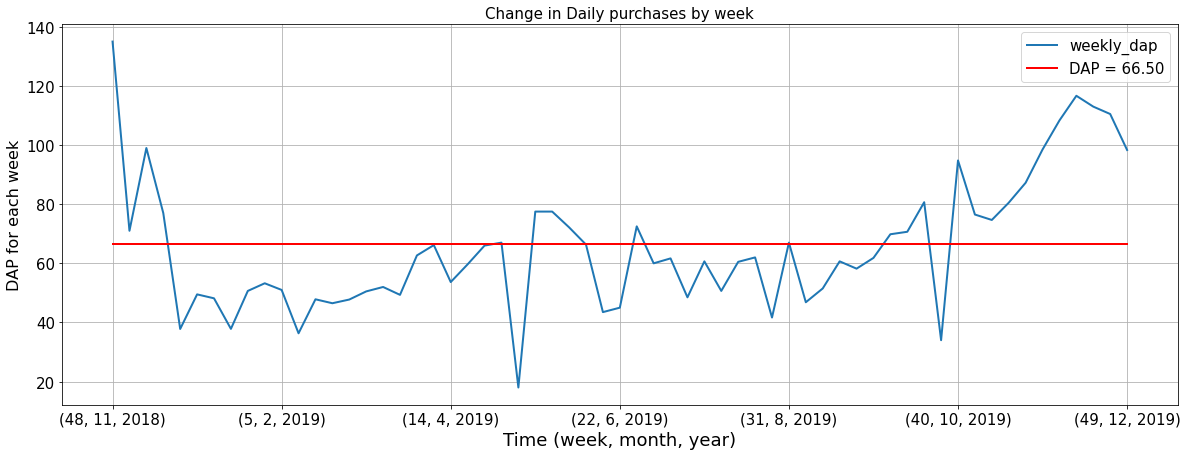

In [63]:
ax = weekly_dap.plot(y = 'weekly_dap', figsize = (20, 7), grid = True, fontsize = 15,   linewidth = 2)
dap.plot(y = 'daily_purchases',figsize = (20, 7), grid = True, fontsize = 15, color = 'r', ax = ax, label = 'DAP = {:.2f}'.format(dap_num), linewidth = 2)
plt.title('Change in Daily purchases by week', fontsize = 15)
plt.xlabel('Time (week, month, year)', fontsize=18)
plt.ylabel('DAP for each week', fontsize=16)
plt.legend(prop={'size': 15})

plt.show()

**The graph above shows the daily average number of purchases for every week. we can see pattern that's probably affected by the time of the year, with rise in sales before the holidays, and much less sales on the holidays themselves.**

#### Individual items and invoices analysis

**Starting to find our flagship products by analyzing products' total quantity and total revenue.<br> I will also add the unit price and number of invoices each item is in.<br>
I will assign position for each item in each of these fields from top to bottom.**

In [64]:
df['revenue'] = df['unit_price'] *  df['quantity']

**I'll start with counting unique versions for items with letters in their stock_code**

In [65]:
combine = df[(~df['stock_code'].str.isdigit()) & (~df['stock_code'].str.isalpha())].reset_index(drop = True)
num_descriptions = combine.groupby('stock_number')['description'].nunique().reset_index()
num_descriptions.rename(columns={'description': 'num_versions'}, inplace=True)

In [66]:
df = df.merge(num_descriptions, on = 'stock_number', how = 'outer')
df['num_versions'].fillna('1', inplace = True)
df['num_versions'] = df['num_versions'].astype('int8')
df['more_than_1'] = df['num_versions'].apply(lambda x: True if (x > 1) else False)

In [67]:
items = df.groupby(['stock_code', 'description', 'stock_number']).agg({'quantity':'sum', 'unit_price':'mean', 'revenue':'sum', 'num_versions':'mean', 'more_than_1': 'mean'}).reset_index()
items.rename(columns={'revenue': 'total_revenue'}, inplace=True)

In [68]:
items = items.groupby('description').agg({'stock_code': 'first',
                                          'stock_number': 'first',
                                          'quantity': 'sum',
                                          'unit_price': 'first',
                                          'total_revenue': 'sum',
                                          'num_versions': 'first',
                                          'more_than_1': 'first'}).reset_index()

In [69]:
items_revenue = position(up(items, 'total_revenue').reset_index(drop = True), 'total_revenue')

items_quantity = position(up(items, 'quantity').reset_index(drop = True), 'quantity')

items_price = position(up(items, 'unit_price').reset_index(drop = True), 'unit_price')

items_invoice_count = df.groupby('stock_code')['invoice_number'].count().reset_index()
up(items_invoice_count, 'invoice_number').reset_index(drop = True)
items_invoice_count.rename(columns = {'invoice_number': 'invoice_count'}, inplace = True)
items_invoice_count = position(items_invoice_count, 'invoice_count')

In [70]:
positions = pd.merge(items_revenue, items_quantity, how = 'left', left_on = ['stock_code','description', 'stock_number', 'quantity', 'unit_price', 'total_revenue', 'num_versions', 'more_than_1'], right_on = ['stock_code','description', 'stock_number', 'quantity', 'unit_price', 'total_revenue', 'num_versions', 'more_than_1'])
positions = pd.merge(positions, items_price, how = 'left', left_on = ['stock_code','description', 'stock_number', 'quantity', 'unit_price', 'total_revenue', 'num_versions', 'more_than_1'], right_on = ['stock_code','description', 'stock_number', 'quantity', 'unit_price', 'total_revenue', 'num_versions', 'more_than_1'])
positions = pd.merge(positions, items_invoice_count,  how = 'left', left_on = ['stock_code',], right_on = ['stock_code'])

In [71]:
positions.filter(['stock_code', 'description', 'total_revenue_position',
                  'quantity_position', 'unit_price_position',
                  'invoice_count_position']).head()

,stock_code,description,total_revenue_position,quantity_position,unit_price_position,invoice_count_position
0,22423,regency cakestand 3 tier,1.0,33.0,107.0,1093.0
1,85123a,white hanging heart t-light holder,2.0,3.0,1416.0,2833.0
2,85099b,jumbo bag red retrospot,3.0,2.0,1923.0,2818.0
3,47566,party bunting,4.0,17.0,772.0,2283.0
4,23084,rabbit night light,5.0,6.0,1918.0,1654.0


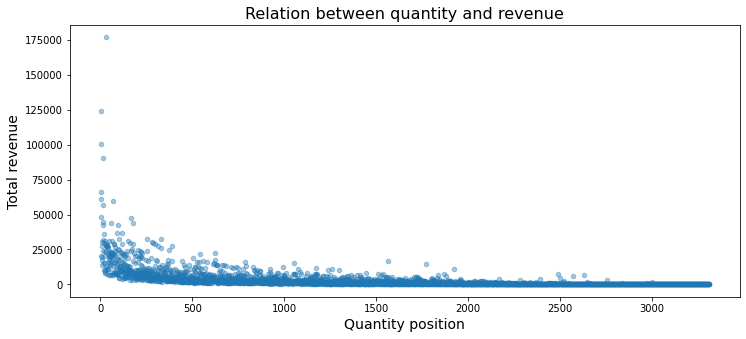

In [72]:
scatter('Relation between quantity and revenue',
     'quantity_position',
     'total_revenue',
     'Quantity position',
     'Total revenue')

**The items that are bought in the highest quantity, generate the highest revenue.**

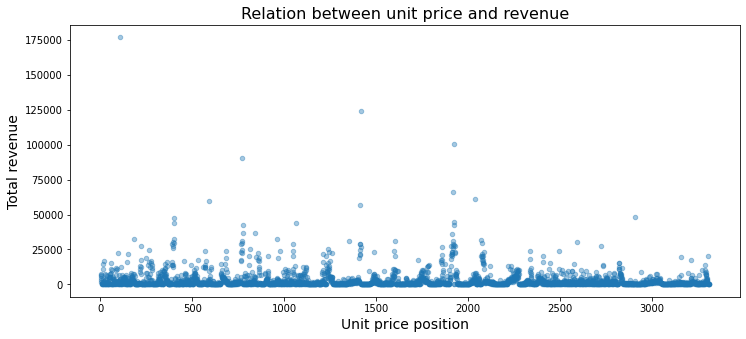

In [73]:
scatter('Relation between unit price and revenue',
     'unit_price_position',
     'total_revenue',
     'Unit price position',
     'Total revenue')

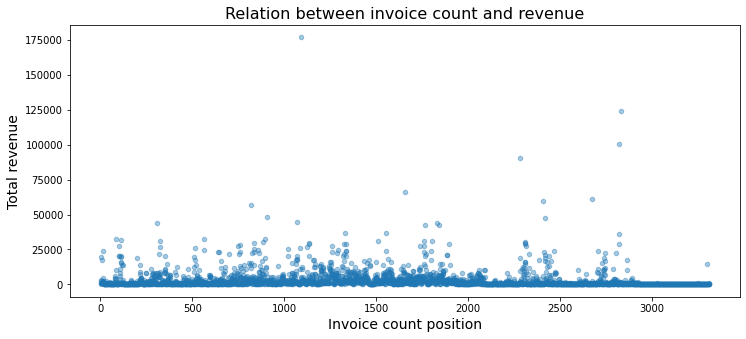

In [74]:
scatter('Relation between invoice count and revenue',
     'invoice_count_position',
     'total_revenue',
     'Invoice count position',
     'Total revenue')

**The items that generate the highest revenue aren't neccesserly the ones that have higher unit price or bought more frequantly.**

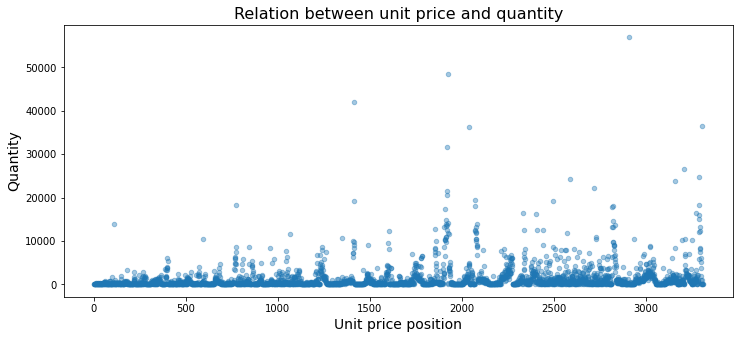

In [75]:
scatter('Relation between unit price and quantity',
     'unit_price_position',
     'quantity',
     'Unit price position',
     'Quantity')

**Items that have relatively low unit price are those that bought in higher quantities**

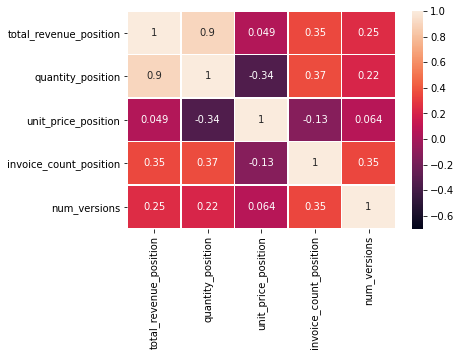

In [76]:
corr = positions.filter(['total_revenue_position', 'quantity_position', 'unit_price_position', 'invoice_count_position', 'num_versions'])
sns.heatmap(corr.corr(), annot = True, linewidth = 0.5, vmin= -0.7, vmax=1)
plt.show()

### Conclusion

**In the products analysis, we have seen that the distribution of purchases during the year is affected by the time of the year, with rise in sales before the holidays, and much less sales on the holidays themselves. <br>
In the correlation heatmap we can see the strong correlation between the quantity and revenue, and very weak correlation between unit price and total revenue or the number of times each item was sold.**

## Finding flagship products

**I will cluster the items based on the features we have found in the earlier stages.<br>
Also will use the description column to find common keywords and stemming those keywords, in order to find cluster the items by keywords.**

### Finding keywords

#### Stemming the description column

In [77]:
positions['stemmed'] = positions['description'].apply(stem_description)

items = positions.copy()

items = items.explode('stemmed')

items.head()

,description,stock_code,stock_number,quantity,unit_price,total_revenue,num_versions,more_than_1,total_revenue_position,quantity_position,unit_price_position,invoice_count,invoice_count_position,stemmed
0,regency cakestand 3 tier,22423,22423,13862,12.75,176740.50,1,False,1.0,33.0,107.0,2009,1093.0,regenc
0,regency cakestand 3 tier,22423,22423,13862,12.75,176740.50,1,False,1.0,33.0,107.0,2009,1093.0,cakestand
0,regency cakestand 3 tier,22423,22423,13862,12.75,176740.50,1,False,1.0,33.0,107.0,2009,1093.0,tier
1,white hanging heart t-light holder,85123a,85123,41937,2.95,123714.15,1,False,2.0,3.0,1416.0,2325,2833.0,white
1,white hanging heart t-light holder,85123a,85123,41937,2.95,123714.15,1,False,2.0,3.0,1416.0,2325,2833.0,hang


In [78]:
keywords = items.groupby('stemmed').agg({'stock_code': 'count',
                                         'quantity': ['mean', 'sum'],
                                         'total_revenue': ['mean', 'sum']}).reset_index()
keywords.columns = ['keyword', 'count', 'avg_quantity',
                    'total_quantity', 'avg_revenue', 'total_revenue']

up(keywords, 'count').head()

,keyword,count,avg_quantity,total_quantity,avg_revenue,total_revenue
1210,set,300,1451.830000,435549,3363.087433,1008926.23
1027,pink,262,930.954198,243910,1778.237290,465898.17
642,heart,229,1689.934498,386995,3544.243755,811631.82
118,blue,185,761.810811,140935,1505.455243,278509.22
1476,vintag,184,1806.206522,332342,3874.608913,712928.04


In [79]:
keywords_count = position(up(keywords, 'count').reset_index(drop = True), 'count')

keywords_avg_quantity = position(up(keywords, 'avg_quantity').reset_index(drop = True), 'avg_quantity')

keywords_quantity = position(up(keywords, 'total_quantity').reset_index(drop = True), 'total_quantity')

keyword_avg_revenue = position(up(keywords, 'avg_revenue').reset_index(drop = True), 'avg_revenue')

keyword_revenue = position(up(keywords, 'total_revenue').reset_index(drop = True), 'total_revenue')

In [80]:
keywords = pd.merge(keywords, keywords_count,  how = 'left', left_on = ['keyword','count', 'avg_quantity', 'total_quantity', 'avg_revenue', 'avg_revenue', 'total_revenue'], right_on = ['keyword','count', 'avg_quantity', 'total_quantity', 'avg_revenue', 'avg_revenue', 'total_revenue'])
keywords = pd.merge(keywords, keywords_avg_quantity,  how = 'left', left_on = ['keyword','count', 'avg_quantity', 'total_quantity', 'avg_revenue', 'avg_revenue', 'total_revenue'], right_on = ['keyword','count', 'avg_quantity', 'total_quantity', 'avg_revenue', 'avg_revenue', 'total_revenue'])
keywords = pd.merge(keywords, keywords_quantity,  how = 'left', left_on = ['keyword','count', 'avg_quantity', 'total_quantity', 'avg_revenue', 'avg_revenue', 'total_revenue'], right_on = ['keyword','count', 'avg_quantity', 'total_quantity', 'avg_revenue', 'avg_revenue', 'total_revenue'])
keywords = pd.merge(keywords, keyword_avg_revenue,  how = 'left', left_on = ['keyword','count', 'avg_quantity', 'total_quantity', 'avg_revenue', 'avg_revenue', 'total_revenue'], right_on = ['keyword','count', 'avg_quantity', 'total_quantity', 'avg_revenue', 'avg_revenue', 'total_revenue'])
keywords = pd.merge(keywords, keyword_revenue,  how = 'left', left_on = ['keyword','count', 'avg_quantity', 'total_quantity', 'avg_revenue', 'avg_revenue', 'total_revenue'], right_on = ['keyword','count', 'avg_quantity', 'total_quantity', 'avg_revenue', 'avg_revenue', 'total_revenue'])

In [81]:
up(keywords, 'count').head()

,keyword,count,avg_quantity,total_quantity,avg_revenue,total_revenue,count_position,avg_quantity_position,total_quantity_position,avg_revenue_position,total_revenue_position
1210,set,300,1451.830000,435549,3363.087433,1008926.23,1.0,341.0,2.0,381.0,2.0
1027,pink,262,930.954198,243910,1778.237290,465898.17,2.0,532.0,11.0,629.0,12.0
642,heart,229,1689.934498,386995,3544.243755,811631.82,3.0,299.0,4.0,354.0,4.0
118,blue,185,761.810811,140935,1505.455243,278509.22,4.0,623.0,23.0,714.0,24.0
1476,vintag,184,1806.206522,332342,3874.608913,712928.04,5.0,279.0,6.0,322.0,6.0


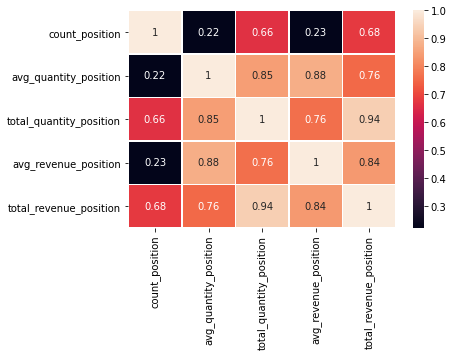

In [82]:
corr = keywords.filter(['count_position', 'avg_quantity_position', 'total_quantity_position', 'avg_revenue_position', 'total_revenue_position'])
sns.heatmap(corr.corr(), annot = True, linewidth = 0.5)
plt.show()

**Items with keywords that were sold alot, also had high revenue. The keywords that appear the most are actually belong to items that aren't very profitable or have high sales rate. <br>
We need to see why the items with the top keywords aren't popular because they are probably a big share of our store.**

#### Counting keywords for each item

In [83]:
words = pd.DataFrame({'keywords': keywords['keyword'], 'word_count':keywords['count']}).set_index('keywords')

In [84]:
positions['1st_word_count'] = (positions['description'].apply(top_keywords))[0]
positions['2nd_word_count'] = (positions['description'].apply(top_keywords))[1]
positions['3rd_word_count'] = (positions['description'].apply(top_keywords))[2]

In [85]:
positions.head()

,description,stock_code,stock_number,quantity,unit_price,total_revenue,num_versions,more_than_1,total_revenue_position,quantity_position,unit_price_position,invoice_count,invoice_count_position,stemmed,1st_word_count,2nd_word_count,3rd_word_count
0,regency cakestand 3 tier,22423,22423,13862,12.75,176740.50,1,False,1.0,33.0,107.0,2009,1093.0,"[regenc, cakestand, tier]",17.0,10.0,2.0
1,white hanging heart t-light holder,85123a,85123,41937,2.95,123714.15,1,False,2.0,3.0,1416.0,2325,2833.0,"[white, hang, heart, holder]",229.0,117.0,103.0
2,jumbo bag red retrospot,85099b,85099,48375,2.08,100620.00,3,True,3.0,2.0,1923.0,2112,2818.0,"[jumbo, bag, red, retrospot]",175.0,155.0,88.0
3,party bunting,47566,47566,18287,4.95,90520.65,1,False,4.0,17.0,772.0,1700,2283.0,"[parti, bunt]",39.0,18.0,NaN
4,rabbit night light,23084,23084,31673,2.08,65879.84,1,False,5.0,6.0,1918.0,1030,1654.0,"[rabbit, night, light]",32.0,27.0,6.0


### Categorising the items

In [86]:
pd.options.display.max_seq_items = 2000

up(words, 'word_count').index

Index(['set', 'pink', 'heart', 'blue', 'vintag', 'red', 'bag', 'box', 'glass',
       'white', 'candl', 'flower', 'christma', 'holder', 'necklac', 'design',
       'metal', 'decor', 'green', 'small', 'larg', 'rose', 'retrospot',
       'black', 'cake', 'hang', 'silver', 'wall', 'garden', 'bead', 'earring',
       'paper', 'bracelet', 'and', 'card', 'with', 'ivori', 'sign', 'cover',
       'egg', 'tin', 'polkadot', 'mirror', 'art', 'mug', 'bowl', 'charm',
       'star', 'cushion', 'crystal', 'tea', 'love', 'cream', 'tree', 'frame',
       'home', 'ring', 'gift', 'wooden', 'easter', 'ceram', 'bottl', 'zinc',
       'letter', 'ribbon', 'bird', 'colour', 'diamant', 'mini', 'parti',
       'clock', 'garland', 'assort', 'drawer', 'butterfli', 'water', 'french',
       'key', 'hook', 'photo', 'antiqu', 'gold', 'stand', 'skull', 'purpl',
       'wood', 'pack', 'enamel', 'girl', 'jar', 'light', 'felt', 'paisley',
       'spot', 'drop', 'plate', 'tray', 'pot', 'dolli', 'sweetheart', 'case',
    

In [87]:
kitchen = ['glass', 'cake', 'mug', 'tea', 'egg', 'bowl', 'bottle', 'jar', 'cup', 'cutlery', 'tray', 'plate', 
           'chocolate', 'water', 'lunch',  'kitchen', 'strawberry', 'coffee', 'tins', 'dinner', 'dish', 'doiley', 
           'jam', 'bunting', 'doily', 'baking', 'cooking', 'candy', 'pan', 'food', 'cherry', 'diner', 'apron', 
           'fruit', 'milk', 'apples', 'cakes', 'breakfast', 'jug', 'napkins', 'biscuit', 'napkin', 'frying', 'coaster',
           'saucer', 'container','snack', 'teatime', 'fridge', 'fuitbowl', 'sugar', 'apple', 'pudding', 'bread', 
           'cookie', 'bakelike', 'wine', 'cups','matches', 'oven', 'spoon', 'plates','recipe', 'squeezer', 'bowls', 
           'pizza', 'toast', 'biscuits', 'salad', 'fork', 'teapot', 'dairy', 'spoons', 'cupcake', 'ladle', 'popcorn', 
           'chopsticks', 'doughnut', 'cakestand', 'teacup', 'cheese', 'microwave', 'coctail', 'foil', 'sweetie', 
           'bake', 'jelly', 'coasters', 'placemats', 'grocery', 'pancake', 'fruitbowl', 'chopping', 'picnic', 'plaster', 'pot', 'sandwich',]

holidays_and_parties = ['christmas', 'easter', 'party', 'garland', 'birthday', 'gift', 'rabbit', 'holiday', 'balloons', 'xmas', 
                        'santa', 'confetti', 'nativity']

home = ['drawer', 'storage', 'knitting', 'drawers', 'box', 'boxes', 'basket', 'chest',
        'hook', 'doormat', 'hand', 'bedroom', 'wastepaper', 'cabinet', 'hanger', 'doorsign', 
        'bathroom', 'towel', 'soap', 'curtain', 'washbag', 'parlour', 'bath', 'towels', 'chair', 'stool',
        'doorstop', 'quilt', 'toilet', 'hooks', 'clothes pegs', 'sewing', 'cover', 'shower', 
        'pin', 'doorknob', 'polkadot', 'peg', 'parasol', 'baskets', 'tissues', 'utilti', 'mat', 'holder',
        'sign', 't-light', 'light', 'lantern', 'cushion', 'mirror', 'clock', 'candles', 'photo', 'picture', 
        'lamp', 'candle', 'candleholder', 'lampshade', 'beaker', 'candlestick', 'ashtray', 'candlepot', 'vase', 
        'wicker', 'chandelier', 't-lights', 'wall', 'art', 'antique', 'vintage', 'decoration', 'fan', 'garage']

garden = ['garden', 'tree', 'flowers', 'daisy', 'torch', 'botanical', 'blossom', 'plant', 'watering', 'holly', 'jardin', 'herb', 'mint',
          'birdhouse', 'rosebud', 'lily', 'chrysanthemum', 'seed', 'planter', 'nest', 'nesting', 'trees', 'cacti', 'gardenia',
          'pots', 'citronella', 'cactus', 'gnome', 'flower', 'rose', 'hammock', 'toadstool', 'flowerpot', 'flytrap', 'grow', 'tree']

appear_and_accessories = ['bag', 'slipper', 'coat', 'glove', 'gloves', 'charm', 'umbrella', 'gloss', 'purse', 'rucksack', 'handbag', 'wallet', 'necklace', 'bracelet', 'earrings', 'ring', 'beads', 'jewelled', 'pendant', 'jewel', 'jewellery', 'brooch'
                          'neckl', 'gemstone', 'bangle', 'necklac', 'pearl', 'brooch', 'diamante', 'backpack', 'sombrero', 'hat']

office_supplies = ['ruler', 'card', 'paper', 'notebook', 'letter', 'pencils', 'book', 'leaf', 'pen', 'stickers', 'alphabet', 
                   'sticker', 'pencil', 'sketchbook', 'pens', 'stationery', 'canvas', 'scissor', 'chalk', 'school', 
                   'envelope', 'books', 'erasers', 'postcard', 'chalkboard', 'stencil', 'paint', 'notebooks', 'organiser',
                   'notepad', 'board', 'crayons', 'ribbon', 'wrap']

kids = ['girl', 'cards', 'patches', 'block', 'gliders', 'clay', 'dolly', 'childrens', 'ball', 'toy', 'jigsaw', 'childs', 'doll', 'baby', 'teddy', 'kids', 'children',
        'girls', 'game', 'playing', 'childhood', 'nursery', 'boys', 'boy', 'toys', 'girly', 'skipping rope', 'toybox', 'stamp', 'bell', 'bunny', 'magic']

In [88]:
positions['category'], positions['category_num'] = zip(*positions['description'].map(categorization))

In [89]:
items = positions.drop(['stemmed'], axis = 1)
items.head()

,description,stock_code,stock_number,quantity,unit_price,total_revenue,num_versions,more_than_1,total_revenue_position,quantity_position,unit_price_position,invoice_count,invoice_count_position,1st_word_count,2nd_word_count,3rd_word_count,category,category_num
0,regency cakestand 3 tier,22423,22423,13862,12.75,176740.50,1,False,1.0,33.0,107.0,2009,1093.0,17.0,10.0,2.0,kitchen,7
1,white hanging heart t-light holder,85123a,85123,41937,2.95,123714.15,1,False,2.0,3.0,1416.0,2325,2833.0,229.0,117.0,103.0,home,6
2,jumbo bag red retrospot,85099b,85099,48375,2.08,100620.00,3,True,3.0,2.0,1923.0,2112,2818.0,175.0,155.0,88.0,appear and accessories,1
3,party bunting,47566,47566,18287,4.95,90520.65,1,False,4.0,17.0,772.0,1700,2283.0,39.0,18.0,NaN,holidays and parties,4
4,rabbit night light,23084,23084,31673,2.08,65879.84,1,False,5.0,6.0,1918.0,1030,1654.0,32.0,27.0,6.0,holidays and parties,4


In [90]:
items.groupby('category')['stock_code'].nunique()

category
appear and accessories     683
garden                     288
holidays and parties       185
home                      1060
kids                       229
kitchen                    287
office supplies            412
other                      166
Name: stock_code, dtype: int64

In [91]:
category = items.groupby('category').agg({'stock_code': 'count',
                                          'total_revenue': ['sum', 'mean'],
                                          'quantity':'mean', 
                                          'unit_price': 'mean'})
category.columns = ['total_items', 'total_revenue', 'avg_revenue_per_item',
                    'avg_quantity', 'avg_item_price']

category = up(category, 'total_revenue')

f = {'total_items':'{:.2f}', 'total_revenue':'{:.2f}', 'avg_revenue_per_item':'{:.2f}',
     'avg_quantity':'{:.2f}', 'avg_item_price':'{:.2f}'}

category.style.format(f).highlight_max(color = '#97DFA1').highlight_min(color = '#FCA965')

,total_items,total_revenue,avg_revenue_per_item,avg_quantity,avg_item_price
category,,,,,
home,1060.00,3715186.45,3504.89,1496.13,4.57
appear and accessories,683.00,1484965.94,2174.18,1133.68,4.00
kitchen,287.00,1456331.95,5074.33,1946.85,3.68
office supplies,412.00,1086511.26,2637.16,1326.78,3.49
kids,229.00,671822.57,2933.72,1275.70,3.25
garden,288.00,578564.75,2008.91,762.81,3.89
holidays and parties,185.00,575746.33,3112.14,1470.36,3.43
other,166.00,306225.61,1844.73,827.02,4.19


**We can start seeing our product range - most of our products belong to the `home` category. <br>
Next we have `appear and accessories` and `office supplies`. The other categories have much less products. In the table we can see that eve though the`kitchen` category have much less products, it surpass the `office supplies` in total revenue and have the highest revenue per item. <br>
We should concider adding more items of that category.**

### Applying macine learning

**Building df for clustering without the category column, so we can later see if there's a pattern and specific categories go in specific clusters.**

In [92]:
items_ml = items[['stock_code',
                  'total_revenue_position', 
                  'quantity_position', 
                  'unit_price_position', 
                  'invoice_count_position',
                  'more_than_1', 
                  '1st_word_count', '2nd_word_count', '3rd_word_count']].set_index('stock_code')

In [93]:
scaler = StandardScaler()
items_st = scaler.fit_transform(items_ml.fillna(0))

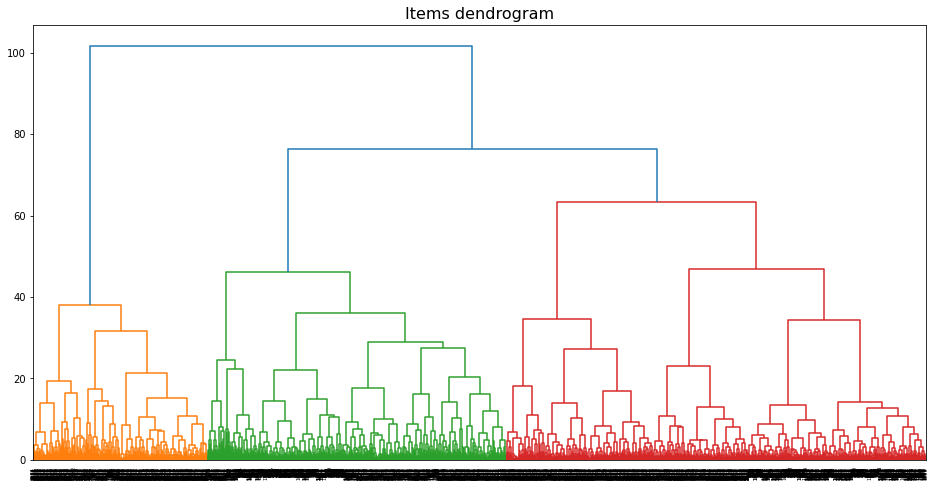

In [92]:
linked = linkage(items_st, method = 'ward')

plt.figure(figsize = (16,8))
dendrogram(linked, orientation = 'top')
plt.title('Items dendrogram', fontsize = 16)
plt.show()

**After reviewing the dendrogram, I will set the number of clusters to 6.**

In [94]:
model_km = KMeans(n_clusters = 6, random_state = 42)

# get labels
labels_km = model_km.fit_predict(items_st)

In [95]:
items['cluster'] = labels_km

clusters = items['cluster'].value_counts().reset_index().rename(columns = {'index': 'cluster',
                                                                           'cluster': 'items_count'})
down(clusters, 'cluster')

,cluster,items_count
0,0,738
4,1,475
2,2,566
5,3,421
3,4,495
1,5,615


### Clusters analysis

#### All clusteres

In [96]:
all_clusters = clusters_table('all_clusters', 'no', 'no')

,total_items,total_revenue,avg_revenue_per_item,avg_quantity,avg_item_price,unique_items,avg_num_versions,more_than_1,revenue_perc
cluster,,,,,,,,,
5,615.00,4132129.84,6718.91,1283.24,7.63,604.00,1.06,0.03,41.84
0,738.00,3368537.53,4564.41,3258.55,1.39,735.00,1.04,0.01,34.11
3,421.00,1908306.40,4532.79,2352.81,3.25,405.00,1.24,0.10,19.32
4,495.00,195982.29,395.92,171.58,3.78,485.00,1.10,0.03,1.98
2,566.00,177060.30,312.83,152.04,3.82,210.00,3.98,1.00,1.79
1,475.00,93338.50,196.50,65.65,4.52,473.00,1.00,0.00,0.95


In [97]:
categories = items.pivot_table(index = 'cluster', columns = 'category', values = 'stock_code', aggfunc = 'count').reset_index()
categories.columns = [''.join(col).strip() for col in categories.columns.values]
categories = categories.set_index('cluster')
categories['total'] = categories.sum(axis = 1)

for column in categories.drop(['total'], axis = 1):
    categories[column] = (categories[column] / categories['total'])

In [98]:
f = {0:'{:.2%}', 1:'{:.2%}', 2:'{:.2%}', 3:'{:.2%}',
     4:'{:.2%}', 5:'{:.2%}', 6:'{:.2%}', 7:'{:.2%}'}

categories.transpose().drop(['total']).style.format(f).highlight_max(color = '#97DFA1').highlight_min(color = '#FCA965')

cluster,0,1,2,3,4,5
appear and accessories,10.70%,27.79%,49.65%,21.38%,10.71%,7.80%
garden,6.23%,9.26%,8.30%,8.79%,11.72%,9.11%
holidays and parties,7.59%,5.05%,3.53%,6.89%,5.86%,4.39%
home,29.13%,26.95%,21.91%,45.84%,32.32%,39.02%
kids,10.84%,4.00%,3.00%,3.09%,7.47%,10.24%
kitchen,12.06%,6.95%,4.59%,4.75%,5.45%,14.96%
office supplies,17.34%,13.89%,5.83%,8.55%,15.76%,11.54%
other,6.10%,6.11%,3.18%,0.71%,10.71%,2.93%


#### Individual clusters

#### Cluster 5

,description,category,total_revenue_position,quantity_position,unit_price_position,invoice_count_position,num_versions,more_than_1
0,regency cakestand 3 tier,kitchen,1.0,33.0,107.0,1093.0,1,False
3,party bunting,holidays and parties,4.0,17.0,772.0,2283.0,1,False
6,chilli lights,home,7.0,67.0,593.0,2404.0,1,False
9,wood black board ant white finish,office supplies,10.0,165.0,399.0,2416.0,1,False
11,doormat keep calm and come in,home,12.0,180.0,401.0,1828.0,1,False


,total_items,total_revenue,avg_revenue_per_item,avg_quantity,avg_item_price,unique_items,avg_num_versions,more_than_1,revenue_perc
category,,,,,,,,,
home,240.00,1659709.38,6915.46,1306.26,8.71,238.00,1.03,0.02,40.17
kitchen,92.00,876840.96,9530.88,1691.36,6.07,92.00,1.01,0.01,21.22
office supplies,71.00,383525.98,5401.77,1174.04,8.29,71.00,1.04,0.01,9.28
kids,63.00,350980.51,5571.12,1205.19,6.38,60.00,1.22,0.08,8.49
garden,56.00,293870.02,5247.68,854.38,7.84,54.00,1.11,0.05,7.11
holidays and parties,27.00,273317.62,10122.87,2153.22,5.17,25.00,1.07,0.07,6.61
appear and accessories,48.00,180426.37,3758.88,823.06,5.86,47.00,1.08,0.06,4.37
other,18.00,113459.00,6303.28,850.61,10.82,18.00,1.00,0.00,2.75


**Total items:** There are 615 items in the cluster <br>                        **Revenue:** <br>                          &emsp; **Total:** 4132129.84 (1, 41.84%) <br>                          &emsp; **Range:** 637.5 - 176740.5 <br>                          &emsp; **Mean:** 6718.91 <br>                         **Quantity:**  <br>                          &emsp; **Total items sold:** 789191 (3) <br>                          &emsp; **Range:** 10.0 - 18287.0 <br>                          &emsp; **Mean:** 1283.24 <br>                          **Categories:** <br>                          &emsp; **1st category:** home (39.02%) <br>                          &emsp; **2nd category:** kitchen (14.96%) <br>                          &emsp; **3rd category:** office supplies (11.54%) <br>                         **Unit price:**  <br>                          &emsp; **Range:** 2.46 - 165.0 <br>                          &emsp; **Mean:** 7.63 <br>                         **Number of versions:**  <br>                          &emsp; **Range:** 1.0 - 4.0 <br>                          &emsp; **Mean:** 1.06 <br>                         **Number of invoices the items appeared in:** <br>                          &emsp; **Total:** 136405.0 (2) <br>                          &emsp; **Range:** 4.0 - 2009.0 <br>                          &emsp; **Mean:** 221.8 <br>

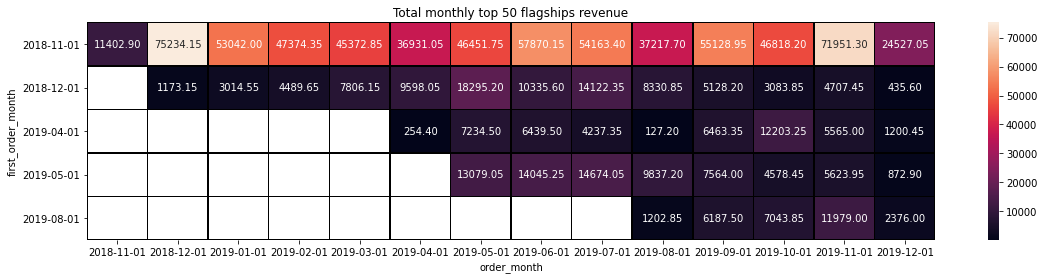

#### Cluster 0

,description,category,total_revenue_position,quantity_position,unit_price_position,invoice_count_position,num_versions,more_than_1
4,rabbit night light,holidays and parties,5.0,6.0,1918.0,1654.0,1,False
5,assorted colour bird ornament,other,6.0,5.0,2037.0,2671.0,1,False
7,paper chain kit 50's christmas,office supplies,8.0,15.0,1414.0,819.0,1,False
8,popcorn holder,home,9.0,1.0,2908.0,905.0,1,False
17,jumbo bag strawberry,appear and accessories,18.0,22.0,1911.0,2820.0,3,True


,total_items,total_revenue,avg_revenue_per_item,avg_quantity,avg_item_price,unique_items,avg_num_versions,more_than_1,revenue_perc
category,,,,,,,,,
home,215.00,1136731.64,5287.12,3752.72,1.47,214.00,1.01,0.01,33.75
appear and accessories,79.00,650569.70,8235.06,5063.18,1.56,79.00,1.03,0.01,19.31
office supplies,128.00,407219.84,3181.41,2402.63,1.30,127.00,1.11,0.02,12.09
kitchen,89.00,384117.96,4315.93,3813.67,1.39,89.00,1.00,0.00,11.40
kids,80.00,271848.89,3398.11,2351.47,1.34,80.00,1.00,0.00,8.07
holidays and parties,56.00,197861.55,3533.24,2373.20,1.26,56.00,1.00,0.00,5.87
garden,46.00,163443.10,3553.11,2703.63,1.28,46.00,1.02,0.02,4.85
other,45.00,156744.85,3483.22,2347.67,1.34,44.00,1.18,0.04,4.65


**Total items:** There are 738 items in the cluster <br>                        **Revenue:** <br>                          &emsp; **Total:** 3368537.53 (2, 34.11%) <br>                          &emsp; **Range:** 188.5 - 65879.84 <br>                          &emsp; **Mean:** 4564.41 <br>                         **Quantity:**  <br>                          &emsp; **Total items sold:** 2404809 (1) <br>                          &emsp; **Range:** 290.0 - 56898.0 <br>                          &emsp; **Mean:** 3258.55 <br>                          **Categories:** <br>                          &emsp; **1st category:** home (29.13%) <br>                          &emsp; **2nd category:** office supplies (17.34%) <br>                          &emsp; **3rd category:** kitchen (12.06%) <br>                         **Unit price:**  <br>                          &emsp; **Range:** 0.5 - 2.95 <br>                          &emsp; **Mean:** 1.39 <br>                         **Number of versions:**  <br>                          &emsp; **Range:** 1.0 - 8.0 <br>                          &emsp; **Mean:** 1.04 <br>                         **Number of invoices the items appeared in:** <br>                          &emsp; **Total:** 197584.0 (1) <br>                          &emsp; **Range:** 3.0 - 1476.0 <br>                          &emsp; **Mean:** 267.73 <br>

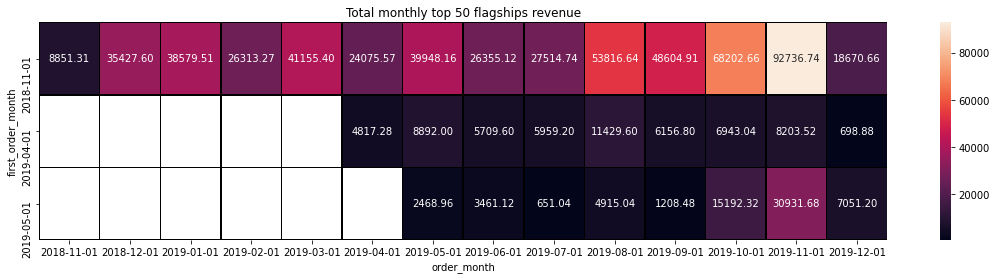

#### Cluster 3

,description,category,total_revenue_position,quantity_position,unit_price_position,invoice_count_position,num_versions,more_than_1
1,white hanging heart t-light holder,home,2.0,3.0,1416.0,2833.0,1,False
2,jumbo bag red retrospot,appear and accessories,3.0,2.0,1923.0,2818.0,3,True
10,jumbo bag pink polkadot,appear and accessories,11.0,12.0,1922.0,1070.0,1,False
13,jumbo bag vintage doily,appear and accessories,14.0,13.0,1921.0,1763.0,1,False
15,set of 3 cake tins pantry design,home,16.0,119.0,774.0,1331.0,1,False


,total_items,total_revenue,avg_revenue_per_item,avg_quantity,avg_item_price,unique_items,avg_num_versions,more_than_1,revenue_perc
category,,,,,,,,,
home,193.00,756367.63,3919.00,2045.28,3.90,185.00,1.24,0.09,39.64
appear and accessories,90.00,577575.16,6417.50,3437.46,2.94,87.00,1.36,0.14,30.27
office supplies,36.00,242935.28,6748.20,3438.28,2.81,36.00,1.00,0.00,12.73
kitchen,20.00,152681.25,7634.06,2364.70,3.56,20.00,1.00,0.00,8.00
holidays and parties,29.00,85315.25,2941.91,2419.00,1.92,29.00,1.03,0.03,4.47
garden,37.00,67440.85,1822.73,709.57,2.57,35.00,1.57,0.27,3.53
kids,13.00,24103.31,1854.10,1296.85,1.95,13.00,1.08,0.08,1.26
other,3.00,1887.67,629.22,695.67,1.32,3.00,1.00,0.00,0.10


**Total items:** There are 421 items in the cluster <br>                        **Revenue:** <br>                          &emsp; **Total:** 1908306.4 (3, 19.32%) <br>                          &emsp; **Range:** 2.51 - 123714.15 <br>                          &emsp; **Mean:** 4532.79 <br>                         **Quantity:**  <br>                          &emsp; **Total items sold:** 990533 (2) <br>                          &emsp; **Range:** 1.0 - 48375.0 <br>                          &emsp; **Mean:** 2352.81 <br>                          **Categories:** <br>                          &emsp; **1st category:** home (45.84%) <br>                          &emsp; **2nd category:** appear and accessories (21.38%) <br>                          &emsp; **3rd category:** garden (8.79%) <br>                         **Unit price:**  <br>                          &emsp; **Range:** 0.55 - 125.0 <br>                          &emsp; **Mean:** 3.25 <br>                         **Number of versions:**  <br>                          &emsp; **Range:** 1.0 - 6.0 <br>                          &emsp; **Mean:** 1.24 <br>                         **Number of invoices the items appeared in:** <br>                          &emsp; **Total:** 91771.0 (3) <br>                          &emsp; **Range:** 1.0 - 2325.0 <br>                          &emsp; **Mean:** 217.98 <br>

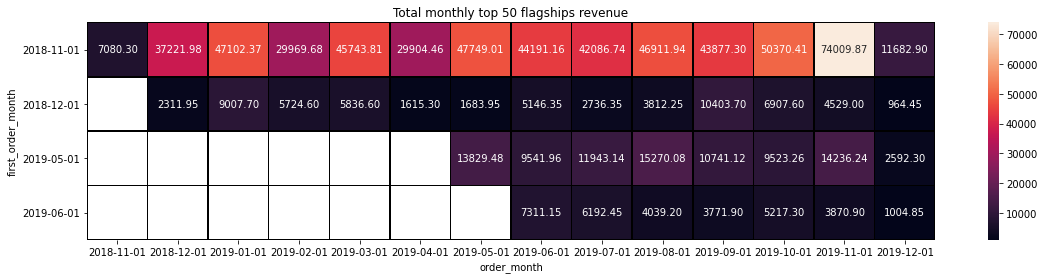

#### Cluster 4

,description,category,total_revenue_position,quantity_position,unit_price_position,invoice_count_position,num_versions,more_than_1
1263,mr robot soft toy,kids,1264.0,1939.0,454.0,99.0,1,False
1303,red retrospot purse,appear and accessories,1304.0,1461.0,1405.0,72.0,1,False
1311,cockle shell dish,kitchen,1312.0,1678.0,940.0,468.0,1,False
1337,pink paper parasol,office supplies,1338.0,1506.0,1372.0,7.0,4,True
1366,blue polkadot passport cover,home,1367.0,1730.0,957.0,55.0,1,False


,total_items,total_revenue,avg_revenue_per_item,avg_quantity,avg_item_price,unique_items,avg_num_versions,more_than_1,revenue_perc
category,,,,,,,,,
home,160.00,66318.52,414.49,168.09,4.63,156.00,1.13,0.04,33.84
office supplies,78.00,29096.07,373.03,174.31,3.34,76.00,1.12,0.04,14.85
appear and accessories,53.00,22918.68,432.43,153.83,2.94,53.00,1.02,0.02,11.69
garden,58.00,19955.95,344.07,144.83,3.16,58.00,1.09,0.02,10.18
other,53.00,18064.62,340.84,177.21,3.13,51.00,1.23,0.08,9.22
kids,37.00,17621.19,476.25,199.49,3.21,37.00,1.00,0.00,8.99
kitchen,27.00,11437.63,423.62,180.70,4.01,27.00,1.00,0.00,5.84
holidays and parties,29.00,10569.63,364.47,215.10,4.66,29.00,1.00,0.00,5.39


**Total items:** There are 495 items in the cluster <br>                        **Revenue:** <br>                          &emsp; **Total:** 195982.29 (4, 1.98%) <br>                          &emsp; **Range:** 1.95 - 1501.2 <br>                          &emsp; **Mean:** 395.92 <br>                         **Quantity:**  <br>                          &emsp; **Total items sold:** 84934 (5) <br>                          &emsp; **Range:** 1.0 - 654.0 <br>                          &emsp; **Mean:** 171.58 <br>                          **Categories:** <br>                          &emsp; **1st category:** home (32.32%) <br>                          &emsp; **2nd category:** office supplies (15.76%) <br>                          &emsp; **3rd category:** garden (11.72%) <br>                         **Unit price:**  <br>                          &emsp; **Range:** 0.5 - 83.33 <br>                          &emsp; **Mean:** 3.78 <br>                         **Number of versions:**  <br>                          &emsp; **Range:** 1.0 - 6.0 <br>                          &emsp; **Mean:** 1.1 <br>                         **Number of invoices the items appeared in:** <br>                          &emsp; **Total:** 20499.0 (4) <br>                          &emsp; **Range:** 1.0 - 157.0 <br>                          &emsp; **Mean:** 41.41 <br>

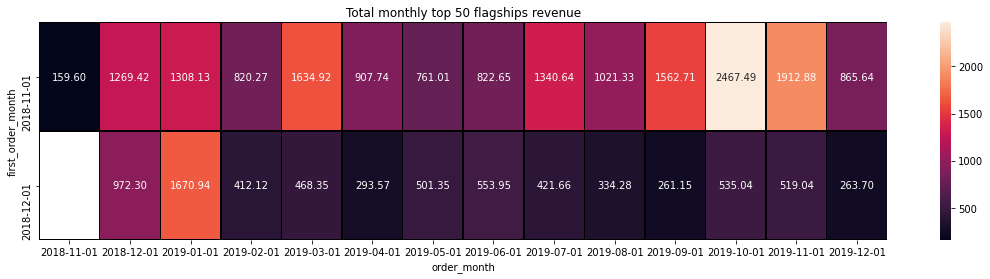

#### Cluster 2

,description,category,total_revenue_position,quantity_position,unit_price_position,invoice_count_position,num_versions,more_than_1
582,ocean scent candle in jewelled box,appear and accessories,583.0,947.0,809.0,2367.0,3,True
672,set of 4 english rose placemats,garden,673.0,969.0,1028.0,2494.0,5,True
735,set of 3 black flying ducks,other,736.0,1353.0,587.0,2143.0,4,True
744,charlie+lola pink hot water bottle,home,745.0,967.0,1205.0,2443.0,2,True
776,set/3 vanilla scented candle in box,home,777.0,1206.0,835.0,2373.0,3,True


,total_items,total_revenue,avg_revenue_per_item,avg_quantity,avg_item_price,unique_items,avg_num_versions,more_than_1,revenue_perc
category,,,,,,,,,
home,124.00,58195.33,469.32,258.02,2.85,64.00,2.94,1.00,32.87
appear and accessories,281.00,37023.82,131.76,43.01,4.54,92.00,5.02,1.00,20.91
kitchen,26.00,24155.59,929.06,343.73,3.24,16.00,2.42,1.00,13.64
garden,47.00,23478.69,499.55,207.23,2.86,28.00,2.74,1.00,13.26
office supplies,33.00,16736.27,507.16,472.88,4.44,12.00,3.61,1.00,9.45
other,18.00,10859.22,603.29,150.22,4.51,9.00,3.17,1.00,6.13
holidays and parties,20.00,3734.49,186.72,153.30,2.68,9.00,3.15,1.00,2.11
kids,17.00,2876.89,169.23,113.24,1.95,8.00,2.59,1.00,1.62


**Total items:** There are 566 items in the cluster <br>                        **Revenue:** <br>                          &emsp; **Total:** 177060.3 (5, 1.79%) <br>                          &emsp; **Range:** 1.25 - 4369.0 <br>                          &emsp; **Mean:** 312.83 <br>                         **Quantity:**  <br>                          &emsp; **Total items sold:** 86057 (4) <br>                          &emsp; **Range:** 1.0 - 1721.0 <br>                          &emsp; **Mean:** 152.04 <br>                          **Categories:** <br>                          &emsp; **1st category:** appear and accessories (49.65%) <br>                          &emsp; **2nd category:** home (21.91%) <br>                          &emsp; **3rd category:** garden (8.3%) <br>                         **Unit price:**  <br>                          &emsp; **Range:** 0.53 - 49.95 <br>                          &emsp; **Mean:** 3.82 <br>                         **Number of versions:**  <br>                          &emsp; **Range:** 2.0 - 23.0 <br>                          &emsp; **Mean:** 3.98 <br>                         **Number of invoices the items appeared in:** <br>                          &emsp; **Total:** 18026.0 (5) <br>                          &emsp; **Range:** 1.0 - 319.0 <br>                          &emsp; **Mean:** 31.85 <br>

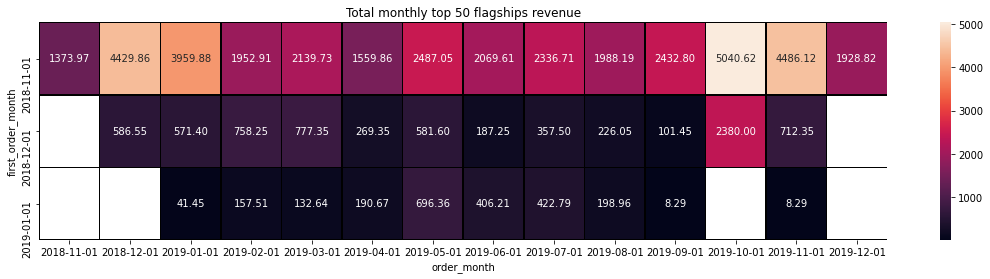

#### Cluster 1

,description,category,total_revenue_position,quantity_position,unit_price_position,invoice_count_position,num_versions,more_than_1
1343,ant white wire heart spiral,home,1344.0,1679.0,976.0,2675.0,1,False
1352,hand towel pale blue w flowers,garden,1353.0,1920.0,554.0,2686.0,1,False
1471,candy spot cushion cover,home,1472.0,1680.0,1176.0,2810.0,1,False
1533,white soap rack with 2 bottles,home,1534.0,2058.0,563.0,2644.0,1,False
1571,small square cut glass candlestick,home,1572.0,1997.0,741.0,2838.0,1,False


,total_items,total_revenue,avg_revenue_per_item,avg_quantity,avg_item_price,unique_items,avg_num_versions,more_than_1,revenue_perc
category,,,,,,,,,
home,128.00,37863.95,295.81,93.23,4.63,128.00,1.00,0.00,40.57
appear and accessories,132.00,16452.21,124.64,39.36,4.79,130.00,1.00,0.00,17.63
garden,44.00,10376.14,235.82,70.05,4.76,44.00,1.00,0.00,11.12
kitchen,33.00,7098.56,215.11,79.21,3.34,33.00,1.00,0.00,7.61
office supplies,66.00,6997.82,106.03,41.83,2.67,66.00,1.00,0.00,7.50
other,29.00,5210.25,179.66,74.03,6.54,29.00,1.00,0.00,5.58
holidays and parties,24.00,4947.79,206.16,63.54,7.49,24.00,1.00,0.00,5.30
kids,19.00,4391.78,231.15,101.32,3.04,19.00,1.00,0.00,4.71


**Total items:** There are 475 items in the cluster <br>                        **Revenue:** <br>                          &emsp; **Total:** 93338.5 (6, 0.95%) <br>                          &emsp; **Range:** 1.25 - 1339.05 <br>                          &emsp; **Mean:** 196.5 <br>                         **Quantity:**  <br>                          &emsp; **Total items sold:** 31182 (6) <br>                          &emsp; **Range:** 1.0 - 444.0 <br>                          &emsp; **Mean:** 65.65 <br>                          **Categories:** <br>                          &emsp; **1st category:** appear and accessories (27.79%) <br>                          &emsp; **2nd category:** home (26.95%) <br>                          &emsp; **3rd category:** office supplies (13.89%) <br>                         **Unit price:**  <br>                          &emsp; **Range:** 0.55 - 59.95 <br>                          &emsp; **Mean:** 4.52 <br>                         **Number of versions:**  <br>                          &emsp; **Range:** 1.0 - 1.0 <br>                          &emsp; **Mean:** 1.0 <br>                         **Number of invoices the items appeared in:** <br>                          &emsp; **Total:** 8170.0 (6) <br>                          &emsp; **Range:** 1.0 - 125.0 <br>                          &emsp; **Mean:** 17.2 <br>

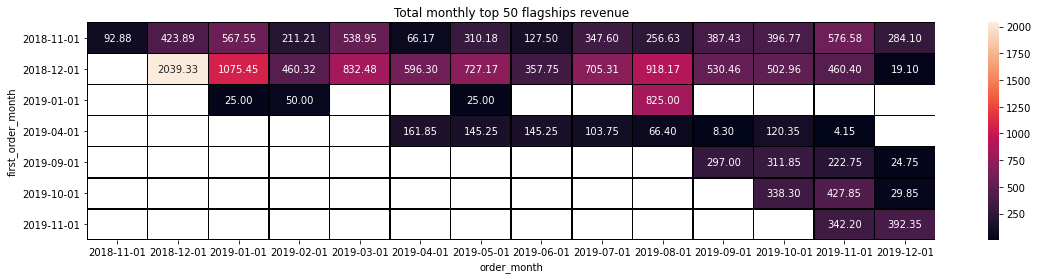

In [99]:
clusters = all_clusters.reset_index()
for i in range(0, len(clusters)):
    cluster_report(clusters.loc[i, 'cluster'])

### Conclusion

**After reviewing the clusters' reports, we can say our most important bundles are clusters 0, 5 and 3 with the categories `home`, `appear and accessories`, `kitchen` and `office supplies`. <br> 
We should look into this clusters, and try to find more products that will fit in them**

## Hypothesis

**1) The clusters with the highest revenue have items with higher unit_price.<br>**
**2) Items with more than 1 version have better sales and revenue.<br>**
**3) Items from the top categories have better sales and revenue.**

### 1st hypothsis

`H0: There is no statistically significant difference in unit_price between top clusters(0, 3, 5) and` &emsp;&emsp; 
`bottom cluster(1, 2, 4)`

`H1: There is statistically significant difference in unit_price between top clusters(0, 3, 5) and`
 &emsp;&emsp; 
     `bottom cluster(1, 2, 4)`

In [159]:
top_clusters = items[(items['cluster'] == 0) | (items['cluster'] == 3) | (items['cluster'] == 5)]
bottom_clusters = items[~((items['cluster'] == 0) | (items['cluster'] == 3) | (items['cluster'] == 5))]

print('Number of top_clusters group items: ',len(top_clusters))
print('Number of bottom_clusters group items: ',len(bottom_clusters))

Number of top_clusters group items:  1774
Number of bottom_clusters group items:  1536


In [160]:
alpha = 0.05

results = st.mannwhitneyu(top_sample['unit_price'], bottom_sample['unit_price'])

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value: 2.1279331346965076e-09
We reject the null hypothesis


### Number of versions 

#### 

`H0: There is no statistically significant difference in revenue between items with 1 version`  
&emsp;&emsp; `and items with more than 1 version`

`H1: There is statistically significant difference in revenue between items with 1 version and items` &emsp;&emsp;`with more than 1 version`

In [161]:
one_version = items[items['num_versions'] == 1]
more_than_1 = items[items['num_versions'] > 1]

In [162]:
alpha = 0.05

results = st.mannwhitneyu(one_version['total_revenue'], more_than_1['total_revenue'])

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value: 1.6287594703917326e-99
We reject the null hypothesis


#### 

`H0: There is no statistically significant difference in sales between items with 1 version`  
&emsp;&emsp; `and items with more than 1 version`

`H1: There is statistically significant difference in sales between items with 1 version and items` &emsp;&emsp;`with more than 1 version`

In [163]:
alpha = 0.05

results = st.mannwhitneyu(one_version['quantity'], more_than_1['quantity'])

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value: 1.7392111206864688e-91
We reject the null hypothesis


### 3rd hypothsis

#### 

`H0: There is no statistically significant difference in revenue between items in top categories`  
&emsp;&emsp; `and items in bottom categories`

`H1: There is statistically significant difference in revenue between items in top categories`  
&emsp;&emsp; `and items in bottom categories`

In [164]:
top_categories = items[(items['category_num'] == '6') |
                       (items['category_num'] == '7') |
                       (items['category_num'] == '1') |
                       (items['category_num'] == '2')]
bottom_categories = items[~((items['category_num'] == '6') |
                            (items['category_num'] == '7') |
                            (items['category_num'] == '1') |
                            (items['category_num'] == '2'))]

In [165]:
alpha = 0.05

results = st.mannwhitneyu(top_categories['total_revenue'], bottom_categories['total_revenue'])

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value: 0.9493571988017467
We can't reject the null hypothesis


`H0: There is no statistically significant difference in sales between items in top categories`  
&emsp;&emsp; `and items in bottom categories`

`H1: There is statistically significant difference in sales between items in top categories`  
&emsp;&emsp; `and items in bottom categories`

In [166]:
alpha = 0.05

results = st.mannwhitneyu(top_categories['quantity'], bottom_categories['quantity'])

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value: 0.10122759578143566
We can't reject the null hypothesis
